In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.core.common import random_state
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, f1_score, recall_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBClassifier

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-01-31 10:24:18.247263: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-31 10:24:18.254968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738319058.264251   24950 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738319058.266963   24950 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-31 10:24:18.276309: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  1


In [3]:
df_train = pd.read_csv('../kagle_data/spaceship/train.csv')
df_test = pd.read_csv('../kagle_data/spaceship/test.csv')

In [43]:
df_train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [44]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


VIP missing data might have some correlation with the amount the passengers has billed at each of the: RoomService, FoodCourt, ShoppingMall, Spa, VRDeck

In [45]:
crm = df_train[['VIP', 'Transported']].dropna().astype(int).copy()

In [46]:
crm.head()

,VIP,Transported
0,0,0
1,0,1
2,1,0
3,0,0
4,0,1


In [47]:
corr_matrix = crm.corr()
corr_matrix

,VIP,Transported
VIP,1.00000,-0.03765
Transported,-0.03765,1.00000


In [48]:
df_train_dropped_s = df_train.copy()
df_train_dropped_s = df_train_dropped_s.drop(['Transported'],axis=1)
df_combined = pd.concat([df_train_dropped_s, df_test], ignore_index=True)

In [49]:
# df_combined = df_combined.drop(['PassengerId'], axis=1)

In [50]:
vip_null_rows = df_combined[df_combined['VIP'].isnull()]
vip_null_rows

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
38,0036_01,Earth,False,F/8/S,55 Cancri e,15.0,NaN,0.0,492.0,48.0,20.0,401.0,Marina Leodger
102,0108_03,Earth,False,G/19/S,TRAPPIST-1e,0.0,NaN,0.0,0.0,0.0,0.0,0.0,Oline Handertiz
145,0165_01,Mars,True,F/37/P,TRAPPIST-1e,35.0,NaN,0.0,0.0,0.0,0.0,0.0,Graven Anche
228,0244_02,Mars,True,F/47/S,55 Cancri e,14.0,NaN,0.0,0.0,0.0,0.0,0.0,Tous Sad
566,0593_01,Mars,False,D/24/P,TRAPPIST-1e,NaN,NaN,43.0,152.0,182.0,1.0,2005.0,Hon Kra
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12770,8875_02,Europa,False,C/330/S,TRAPPIST-1e,32.0,NaN,26.0,1708.0,0.0,3993.0,481.0,Alar Oillicaly
12780,8895_01,Europa,True,C/294/P,TRAPPIST-1e,39.0,NaN,0.0,0.0,0.0,0.0,0.0,Astrak Hossive
12869,9058_01,Mars,False,NaN,TRAPPIST-1e,38.0,NaN,784.0,0.0,42.0,38.0,10.0,Hammet Muff
12943,9228_01,Earth,False,F/1887/P,TRAPPIST-1e,21.0,NaN,640.0,0.0,21.0,0.0,76.0,Davis Bulliamoses


In [51]:
df_combined['VIP'].unique()

array([False, True, nan], dtype=object)

In [52]:
vip_df = df_combined.dropna(subset=['VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])
vip_df['VIP'].astype(int)

0        0
1        0
2        1
3        0
4        0
        ..
12965    0
12966    0
12967    0
12968    0
12969    0
Name: VIP, Length: 11334, dtype: int64

In [53]:
vip_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11334 entries, 0 to 12969
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   11334 non-null  object 
 1   HomePlanet    11080 non-null  object 
 2   CryoSleep     11061 non-null  object 
 3   Cabin         11070 non-null  object 
 4   Destination   11097 non-null  object 
 5   Age           11096 non-null  float64
 6   VIP           11334 non-null  object 
 7   RoomService   11334 non-null  float64
 8   FoodCourt     11334 non-null  float64
 9   ShoppingMall  11334 non-null  float64
 10  Spa           11334 non-null  float64
 11  VRDeck        11334 non-null  float64
 12  Name          11075 non-null  object 
dtypes: float64(6), object(7)
memory usage: 1.2+ MB


<function matplotlib.pyplot.show(close=None, block=None)>

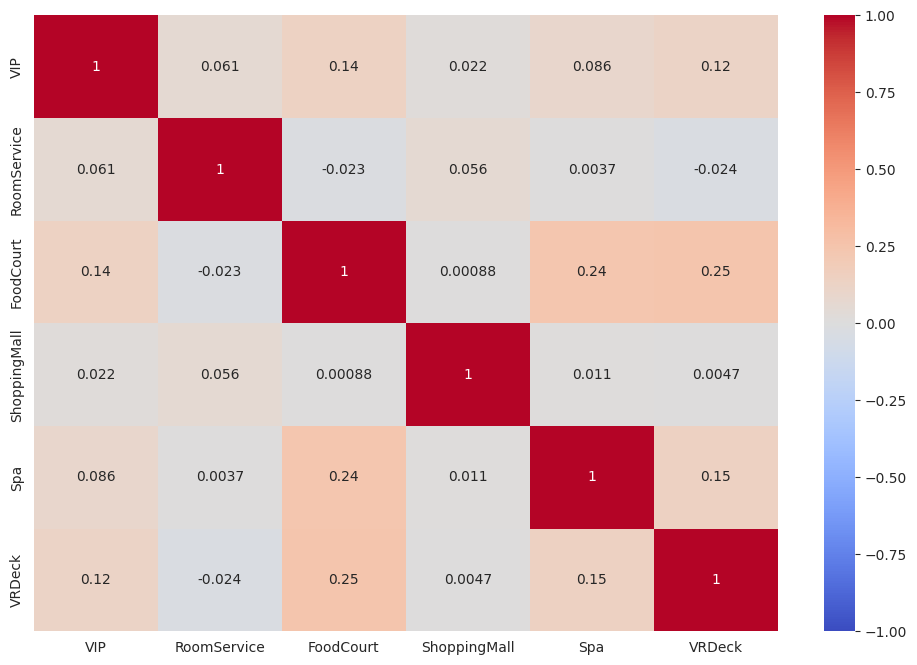

In [54]:
vip_numeric = vip_df[['VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].copy()

corr_matrix = vip_numeric.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show

In [55]:
from sklearn.feature_selection import mutual_info_classif

X = vip_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]
y = vip_df['VIP']

mi_scores = mutual_info_classif(X, y, discrete_features=False)
mi_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_df = mi_df.sort_values(by="MI Score", ascending=False)
print(mi_df)

ValueError: Unknown label type: unknown. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

There's almost no corr between the amount the passengers has billed at each of the: RoomService, FoodCourt, ShoppingMall, Spa, VRDeck

In [56]:
columns_to_fill = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df_combined.loc[df_combined['CryoSleep'] == True, columns_to_fill] = df_combined.loc[df_combined['CryoSleep'] == True, columns_to_fill].fillna(0)
df_combined.loc[:, columns_to_fill] = df_combined.loc[:, columns_to_fill].fillna(df_combined[columns_to_fill].median())

In [57]:
df_combined['SumSpend'] = df_combined['RoomService'] + df_combined['FoodCourt'] + df_combined['ShoppingMall'] + df_combined['Spa'] + df_combined['VRDeck']

In [58]:
df_combined.loc[(df_combined['SumSpend'] > 0) & (df_combined['CryoSleep'].isnull()), 'CryoSleep'] = False
df_combined.loc[(df_combined['SumSpend'] == 0) & (df_combined['CryoSleep'].isnull()), 'CryoSleep'] = True
df_combined = df_combined.drop(['VIP'], axis=1)

In [59]:
df_combined['Age'] = df_combined['Age'].fillna(0)
mode_value = df_combined['Destination'].mode()[0]
df_combined['Destination'] = df_combined['Destination'].fillna(mode_value)

In [60]:
df_combined['HomePlanet'] = df_combined['HomePlanet'].fillna('None')

In [61]:
df_combined['PassengerGroup'] = df_combined['PassengerId'].str.strip('_')[0]

In [62]:
df_combined['Cabin'] = df_combined.groupby('PassengerGroup')['Cabin'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

/tmp/ipykernel_19135/3888904175.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_combined['Cabin'] = df_combined.groupby('PassengerGroup')['Cabin'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [63]:
df_combined = df_combined.drop(['Name'], axis=1)

In [67]:
df_combined['CabinNum'] = df_combined['Cabin'].str.split('/').str[1].astype(int)

In [68]:
df_combined.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,SumSpend,CabinNum
count,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000
mean,28.173015,218.378026,441.890979,170.779491,301.722282,300.450270,1433.221049,603.123593
std,14.817542,641.766201,1568.038076,584.153630,1118.746785,1168.655639,2807.369708,513.119696
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,169.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,716.000000,431.000000
75%,37.000000,42.750000,62.750000,23.000000,50.000000,36.000000,1442.000000,1008.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,35987.000000,1894.000000


In [66]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     12970 non-null  object 
 1   HomePlanet      12970 non-null  object 
 2   CryoSleep       12970 non-null  object 
 3   Cabin           12970 non-null  object 
 4   Destination     12970 non-null  object 
 5   Age             12970 non-null  float64
 6   RoomService     12970 non-null  float64
 7   FoodCourt       12970 non-null  float64
 8   ShoppingMall    12970 non-null  float64
 9   Spa             12970 non-null  float64
 10  VRDeck          12970 non-null  float64
 11  SumSpend        12970 non-null  float64
 12  PassengerGroup  12970 non-null  object 
 13  CabinNum        12970 non-null  object 
dtypes: float64(7), object(7)
memory usage: 1.4+ MB


In [29]:
df_deck_num = df_train.copy()

In [30]:
df_deck_num = df_deck_num.dropna(subset=['Cabin'])

In [31]:
df_deck_num.loc[:, 'CabinNum'] = df_deck_num['Cabin'].str.split('/').str.get(1)

In [32]:
df_deck_num['CabinNum'] = df_deck_num['CabinNum'].astype(int)
df_deck_num['Transported'] = df_deck_num['Transported'].astype(int)

df_deck_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8494 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8494 non-null   object 
 1   HomePlanet    8299 non-null   object 
 2   CryoSleep     8284 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8316 non-null   object 
 5   Age           8319 non-null   float64
 6   VIP           8297 non-null   object 
 7   RoomService   8317 non-null   float64
 8   FoodCourt     8316 non-null   float64
 9   ShoppingMall  8288 non-null   float64
 10  Spa           8313 non-null   float64
 11  VRDeck        8310 non-null   float64
 12  Name          8296 non-null   object 
 13  Transported   8494 non-null   int64  
 14  CabinNum      8494 non-null   int64  
dtypes: float64(6), int64(2), object(7)
memory usage: 1.0+ MB


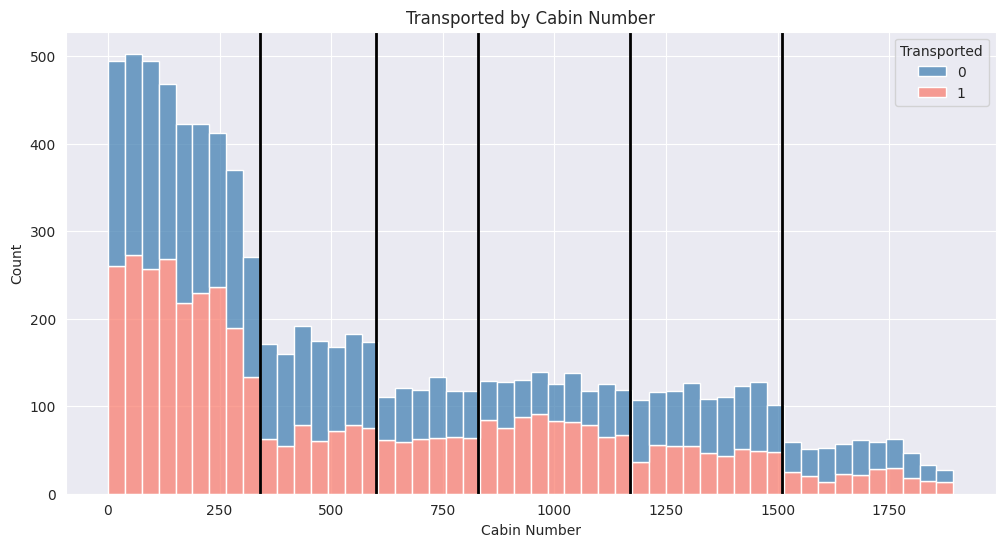

In [40]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df_deck_num, x='CabinNum', hue='Transported', bins=50, multiple="stack", palette={0: "steelblue", 1: "salmon"})

for x in [340, 600, 830,1170, 1510]:
    plt.axvline(x, color='black', linewidth=2)

plt.xlabel('Cabin Number')
plt.ylabel('Count')
plt.title('Transported by Cabin Number')

plt.show()

Might be worth to split cabin number to 4 sets (0:340, 340:600, 600:1510, 1510:inf)


If CryoSleep is True missing data in amount spend can be filled with 0, otherwise filled with median of collumn


Drop VIP if missing

Create sum of the columns with spendings and drop them
To add more value to CryoSleep ad the boolean colum indicating if passenger spend some money

Make columns with informatino about if passenger is traveling solo or not

? Group size col

Cabin split to: Deck, Num? , Side



In [87]:

class FeatureEngineer:
    def __init__(self):
        self.columns_to_fill = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
        self.medians = None
        self.destination_mode = None
        self.cabin_by_group = None
        self.cabin_mode = None
        self.age_bins = [0, 18, 40, 60, 100]
        self.age_labels = [1, 2, 3, 4]
        self.cabin_num_bins = [0, 340, 600, 830,1170, 1510, 3000]
        self.cabin_num_labels = [1, 2, 3, 4, 5, 6]

    def fit(self, X, y=None):
        temp_df = X.copy()

        temp_df.loc[temp_df['CryoSleep'] == True, self.columns_to_fill] = 0
        self.medians = temp_df[self.columns_to_fill].median()

        temp_df['SumSpend'] = temp_df[self.columns_to_fill].sum(axis=1)
        temp_df.loc[(temp_df['SumSpend'] > 0) & temp_df['CryoSleep'].isna(), 'CryoSleep'] = False
        temp_df.loc[(temp_df['SumSpend'] == 0) & temp_df['CryoSleep'].isna(), 'CryoSleep'] = True

        temp_df['Age'] = temp_df['Age'].fillna(0)
        self.destination_mode = temp_df['Destination'].mode()[0]
        temp_df['HomePlanet'] = temp_df['HomePlanet'].fillna('None')

        temp_df['PassengerGroup'] = temp_df['PassengerId'].str.split('_').str[0]
        temp_df['Cabin'] = temp_df.groupby('PassengerGroup')['Cabin'].ffill().bfill()
        self.cabin_by_group = temp_df.groupby('PassengerGroup')['Cabin'].first().to_dict()
        self.cabin_mode = temp_df['Cabin'].mode()[0]

        return self

    def transform(self, X):
        X = X.copy()

        X.loc[X['CryoSleep'] == True, self.columns_to_fill] = 0
        X[self.columns_to_fill] = X[self.columns_to_fill].fillna(self.medians)

        X['SumSpend'] = X[self.columns_to_fill].sum(axis=1)
        X['AgeGroup'] = pd.cut(X['Age'], bins=self.age_bins, labels=self.age_labels, right=False).astype(float).fillna(1)
        X['PassengerGroup'] = X['PassengerId'].str.split('_').str[0]

        X['Cabin'] = X['PassengerGroup'].map(self.cabin_by_group).fillna(self.cabin_mode)
        X['Deck'] = X['Cabin'].str.split('/').str[0]
        X['CabinNum'] = X['Cabin'].str.split('/').str[1].astype(float)
        X['CabinNum'] = pd.cut(X['CabinNum'], bins=self.cabin_num_bins, labels=self.cabin_num_labels, right=False).astype(int)
        X['Side'] = X['Cabin'].str.split('/').str[-1]

        return X.drop(columns=['Cabin', 'PassengerId', 'Name', 'VIP'], errors='ignore')


In [88]:
df_combined_2 = pd.concat([df_train.drop('Transported', axis=1), df_test], ignore_index=True)
fe = FeatureEngineer().fit(df_combined_2)
df_train_clean = fe.transform(df_train)

In [89]:
df_train_clean

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,SumSpend,AgeGroup,PassengerGroup,Deck,CabinNum,Side
0,Europa,False,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,False,0.0,2.0,0001,B,1,P
1,Earth,False,TRAPPIST-1e,24.0,109.0,9.0,25.0,549.0,44.0,True,736.0,2.0,0002,F,1,S
2,Europa,False,TRAPPIST-1e,58.0,43.0,3576.0,0.0,6715.0,49.0,False,10383.0,3.0,0003,A,1,S
3,Europa,False,TRAPPIST-1e,33.0,0.0,1283.0,371.0,3329.0,193.0,False,5176.0,2.0,0003,A,1,S
4,Earth,False,TRAPPIST-1e,16.0,303.0,70.0,151.0,565.0,2.0,True,1091.0,1.0,0004,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,0.0,6819.0,0.0,1643.0,74.0,False,8536.0,3.0,9276,A,1,P
8689,Earth,True,PSO J318.5-22,18.0,0.0,0.0,0.0,0.0,0.0,False,0.0,2.0,9278,G,5,S
8690,Earth,False,TRAPPIST-1e,26.0,0.0,0.0,1872.0,1.0,0.0,True,1873.0,2.0,9279,G,5,S
8691,Europa,False,55 Cancri e,32.0,0.0,1049.0,0.0,353.0,3235.0,False,4637.0,2.0,9280,E,3,S


In [91]:
def create_preprocessor():
    numerical_features = ['Age', 'AgeGroup', 'SumSpend', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CabinNum']
    categorical_features = ['HomePlanet', 'Destination', 'Deck', 'Side', 'PassengerGroup']
    binary_features = ['CryoSleep']

    return ColumnTransformer([
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('binary', 'passthrough', binary_features)
    ])


In [97]:
from sklearn.model_selection import GridSearchCV


def build_pipeline(model_type='rf'):
    pipeline = Pipeline([
        ('feature_engineer', FeatureEngineer()),
        ('preprocessor', create_preprocessor()),
        ('classifier', None)
    ])
    model_configs = {
        'rf': RandomForestClassifier(
            n_estimators=2000,
            max_depth=9,
            max_features=0.5,
            min_samples_split=2,
            class_weight='balanced'
        ),
        'xgb': XGBClassifier(
            n_estimators=2000,
            max_depth=6,
            learning_rate=0.003,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0.4,
            min_child_weight=3,
            reg_alpha=0.5,
            reg_lambda=1.5,
            eval_metric='logloss',
            n_jobs=-1,
            random_state=42,
            tree_method='hist',
            device='cuda',
            max_bin=256,
            scale_pos_weight=0.9,
        )
    }

    if model_type not in model_configs:
        raise ValueError(f"Invalid model_type. Choose from {list(model_configs.keys())}")

    pipeline.set_params(classifier=model_configs[model_type])

    return pipeline

In [98]:
from sklearn.model_selection import train_test_split

def prepare_data(df, is_train=True):
    if is_train:
        y = df['Transported'].astype(int)
        X = df.drop('Transported', axis=1)
        return train_test_split(X, y, test_size=0.2, random_state=42)
        # return X, y
    return df.drop('Transported', axis=1, errors='ignore')



In [99]:
from sklearn.metrics import precision_score, accuracy_score


def submission(train_df, test_df):
    combined = pd.concat([train_df.drop('Transported', axis=1), test_df], axis=0)
    FeatureEngineer().fit(combined)

    # pipeline = build_pipeline()
    X_train, X_val, y_train, y_val = prepare_data(train_df)

    # rf_pipeline = build_pipeline(model_type='rf')

    xgb_pipeline = build_pipeline(model_type='xgb')

    xgb_pipeline.fit(X_train, y_train)

    y_val_preds = xgb_pipeline.predict(X_val)

    accuracy = accuracy_score(y_val, y_val_preds)
    precision = precision_score(y_val, y_val_preds)
    recall = recall_score(y_val, y_val_preds)
    f1 = f1_score(y_val, y_val_preds)

    # test_preds = xgb_pipeline.predict(test_df)

    # submission_df = pd.DataFrame({
    #     'PassengerId': test_df['PassengerId'],
    #     'Transported': test_preds.astype(bool)
    #
    # })
    # submission_df.to_csv('submission.csv', index=False)

    # return submission_df
    return {
        "acc": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [100]:
submission(train_df=df_train, test_df=df_test)


{'acc': 0.7929844738355377,
 'precision': np.float64(0.7720588235294118),
 'recall': np.float64(0.837129840546697),
 'f1': np.float64(0.8032786885245902)}